# Sentiment analysis for stock price prediction


#### Introduction

This notebook ...

In [100]:
# Ensure correct packages and settings
import os
import sys
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Check if running within a virtual environment
if sys.prefix != sys.base_prefix:
    print(f"Running in a virtual environment: {sys.prefix}")
else:
    print("Not running in a virtual environment. Activate the environment, install the packages and try again.")
    sys.exit(1)

Running in a virtual environment: c:\mainrism\imp\enterprises\projects\tweet-stock-sentiment\.venv


### Import Tweet dataset

In [ ]:
# Import NVDA tweets CSV into a DataFrame
nvda_tweets = pd.read_csv(Path("data/nvda-tweets.csv"))

# Remove all rows where 'Datetime' is not a valid date
nvda_tweets = nvda_tweets[pd.to_datetime(nvda_tweets['Datetime'], errors='coerce').notnull()]

# Convert 'Datetime' column to 'Date' in YYYY-MM-DD format
nvda_tweets['Date'] = pd.to_datetime(nvda_tweets['Datetime']).dt.date

# Remove unnammed columns
nvda_tweets = nvda_tweets.loc[:, ~nvda_tweets.columns.str.contains('^Unnamed')]

# Move Date to the first column
colsToShow = nvda_tweets.columns.tolist()
colsToShow = [colsToShow[-1]] + colsToShow[:-1]
nvda_tweets = nvda_tweets[colsToShow]

# First and last dates
firstDate = nvda_tweets['Date'].min()
lastDate = nvda_tweets['Date'].max()
print(f"First date: {firstDate}, Last date: {lastDate}")

# Sort by Date ascending
nvda_tweets = nvda_tweets.sort_values(by='Date')

# Previews
nvda_tweets.head()


First date: 2022-11-21, Last date: 2023-02-06


,Date,Datetime,Tweet Id,Text,Username
100846,2022-11-21,2022-11-21 14:30:16+00:00,1.594700e+18,$NFLX $290 to $295. Over $295 to $297-$300-$30...,Turbobob129
100403,2022-11-21,2022-11-21 19:33:25+00:00,1.594776e+18,"“Most winning trading community, Get next winn...",Smith28301
100402,2022-11-21,2022-11-21 19:37:51+00:00,1.594777e+18,**Most profitable trading community. Get up to...,nappedonthebed
100401,2022-11-21,2022-11-21 19:38:53+00:00,1.594777e+18,**Most profitable trading \nhttps://t.co/U9AUM...,Trades75699329
100400,2022-11-21,2022-11-21 19:39:09+00:00,1.594777e+18,"Best place for day trading, swing trading, sto...",Smith28301


### Import stock prices dataset

In [88]:
# Import NVDA daily stock prices CSV into a DataFrame
nvda_prices = pd.read_csv(Path("data/nvda-daily-stock-prices.csv"))

# Truncate to only the date range of the tweets
nvda_prices['Date'] = pd.to_datetime(nvda_prices['Date']).dt.date
nvda_prices = nvda_prices[(nvda_prices['Date'] >= firstDate) & (nvda_prices['Date'] <= lastDate)]

# Sort by Date ascending
nvda_prices = nvda_prices.sort_values(by='Date')

# Amount of data
print(f"NVDA stock prices data points: {len(nvda_prices)}")

# Preview
nvda_prices.head()

NVDA stock prices data points: 52


,Date,Adj Close,Close,High,Low,Open,Volume
5998,2022-11-21,15.301953,15.317000,15.477000,15.080000,15.147000,404739000
5999,2022-11-22,16.022243,16.038000,16.058001,15.122000,15.328000,472866000
6000,2022-11-23,16.502769,16.518999,16.527000,16.048000,16.098000,427241000
6001,2022-11-25,16.254019,16.270000,16.487000,16.172001,16.318001,167934000
6002,2022-11-28,15.811451,15.827000,16.357000,15.725000,16.025999,303741000


### Adding new features to the Tweet dataset

In [77]:
# Add sentiment analysis columns to the Tweets DataFrame
nvda_tweets['Positive'] = 0
nvda_tweets['Negative'] = 0
nvda_tweets['Neutral'] = 0
nvda_tweets['Compound'] = 0.0
nvda_tweets['Sentiment'] = ''

# Iterate over each tweet and calculate sentiment scores
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
for index, row in nvda_tweets.iterrows():
    tweet = row['Text']
    vs = analyzer.polarity_scores(tweet)
    nvda_tweets.at[index, 'Positive'] = vs['pos']
    nvda_tweets.at[index, 'Negative'] = vs['neg']
    nvda_tweets.at[index, 'Neutral'] = vs['neu']
    nvda_tweets.at[index, 'Compound'] = vs['compound']
    if vs['compound'] >= 0.05:
        nvda_tweets.at[index, 'Sentiment'] = 'Positive'
    elif vs['compound'] <= -0.05:
        nvda_tweets.at[index, 'Sentiment'] = 'Negative'
    else:
        nvda_tweets.at[index, 'Sentiment'] = 'Neutral'

nvda_tweets.head()



C:\Users\adelr\AppData\Local\Temp\ipykernel_20376\3218778040.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.298' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  nvda_tweets.at[index, 'Positive'] = vs['pos']
C:\Users\adelr\AppData\Local\Temp\ipykernel_20376\3218778040.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.702' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  nvda_tweets.at[index, 'Neutral'] = vs['neu']
C:\Users\adelr\AppData\Local\Temp\ipykernel_20376\3218778040.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.085' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  nvda_tweets.at[index, 'Negativ

,Date,Datetime,Tweet Id,Text,Username,Positive,Negative,Neutral,Compound,Sentiment
100846,2022-11-21,2022-11-21 14:30:16+00:00,1.594700e+18,$NFLX $290 to $295. Over $295 to $297-$300-$30...,Turbobob129,0.000,0.0,1.000,0.0000,Neutral
100403,2022-11-21,2022-11-21 19:33:25+00:00,1.594776e+18,"“Most winning trading community, Get next winn...",Smith28301,0.298,0.0,0.702,0.7783,Positive
100402,2022-11-21,2022-11-21 19:37:51+00:00,1.594777e+18,**Most profitable trading community. Get up to...,nappedonthebed,0.129,0.0,0.871,0.7264,Positive
100401,2022-11-21,2022-11-21 19:38:53+00:00,1.594777e+18,**Most profitable trading \nhttps://t.co/U9AUM...,Trades75699329,0.202,0.0,0.798,0.7264,Positive
100400,2022-11-21,2022-11-21 19:39:09+00:00,1.594777e+18,"Best place for day trading, swing trading, sto...",Smith28301,0.208,0.0,0.792,0.6369,Positive


### Adding new features to the Stock Prices dataset

Sentiment
Positive    52
Name: count, dtype: int64
Lowest Compound: 0.1689550285463329, Highest Compound: 0.2711291763341067, Average Compound: 0.21040070882287104


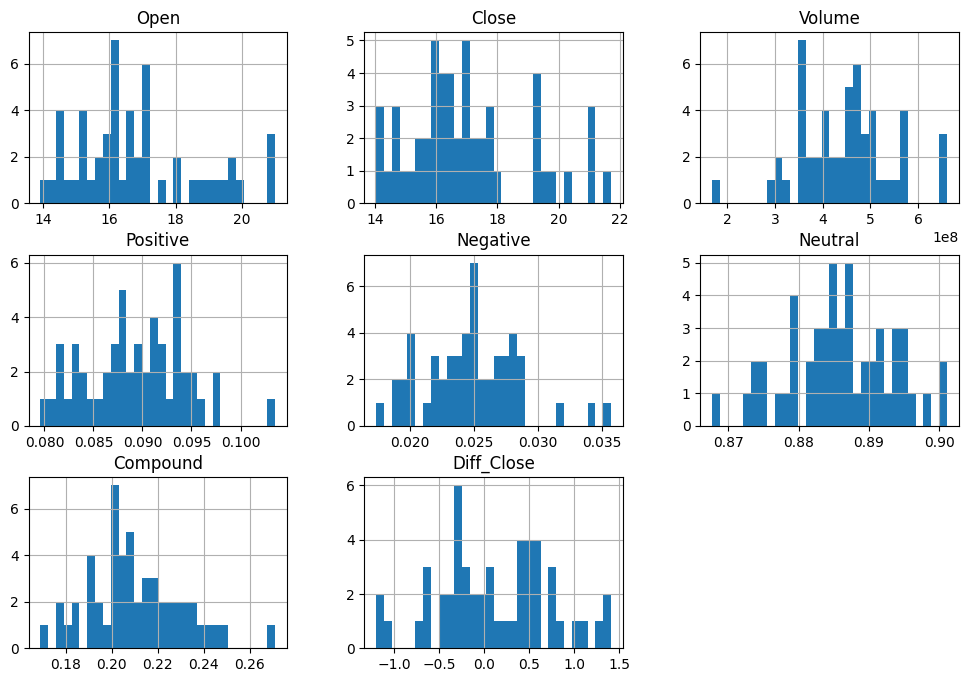

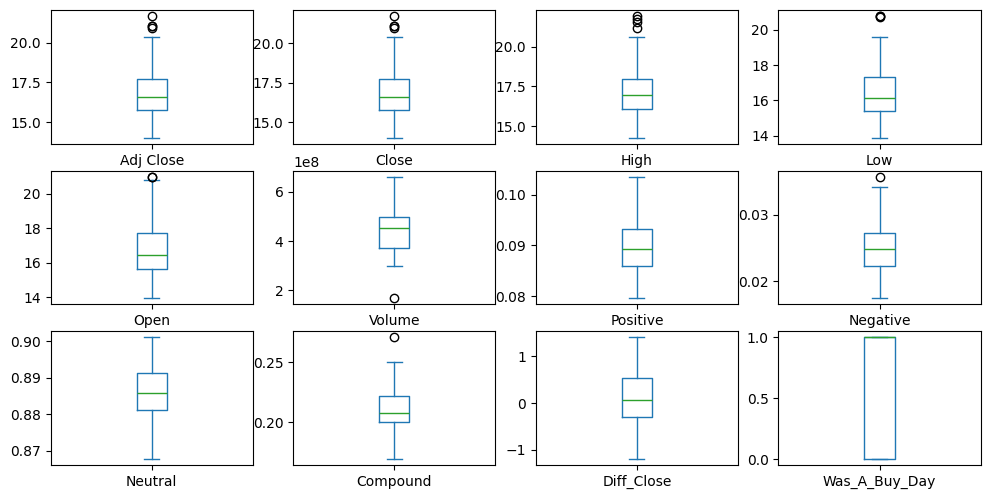

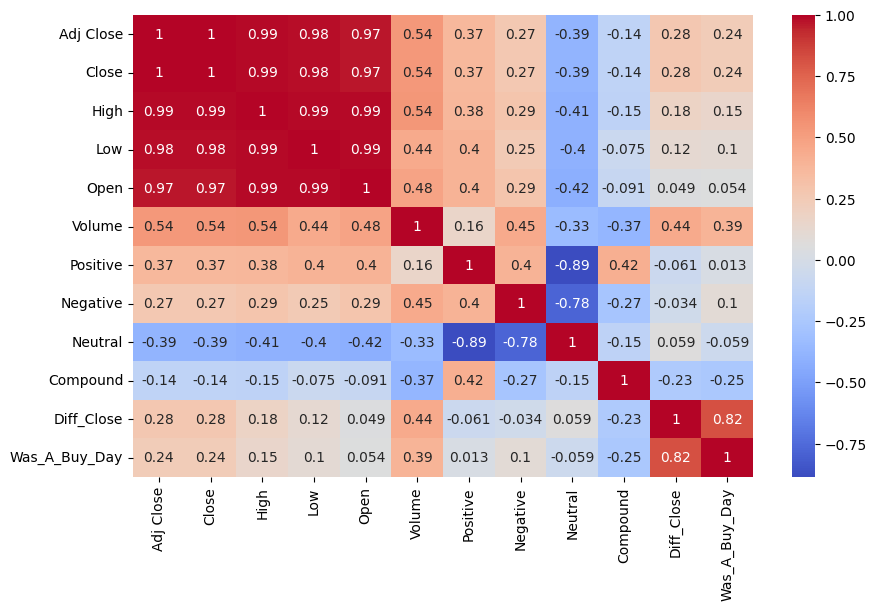

In [122]:
# Add the average sentiment scores per day to the stock prices DataFrame
daily_sentiment = nvda_tweets.groupby('Date').agg({
    'Positive': 'mean',
    'Negative': 'mean',
    'Neutral': 'mean',
    'Compound': 'mean'
}).reset_index()

# Merge daily sentiment with stock prices on 'Date'
nvda_prices_and_sentiment = pd.merge(nvda_prices, daily_sentiment, on='Date', how='left')
nvda_prices_and_sentiment.head()

# Add a 'Sentiment' column based on the 'Compound' score
def sentiment_from_compound(compound):
    if pd.isna(compound):
        return 'No Data'
    elif compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

nvda_prices_and_sentiment['Sentiment'] = nvda_prices_and_sentiment['Compound'].apply(sentiment_from_compound)

# Sort by Date ascending
nvda_prices_and_sentiment = nvda_prices_and_sentiment.sort_values(by='Date')

# Count how many days have each sentiment
print(nvda_prices_and_sentiment['Sentiment'].value_counts())

# Get the lowest, highest, and average Compound scores
lowest_compound = nvda_prices_and_sentiment['Compound'].min()
highest_compound = nvda_prices_and_sentiment['Compound'].max()
average_compound = nvda_prices_and_sentiment['Compound'].mean()
print(f"Lowest Compound: {lowest_compound}, Highest Compound: {highest_compound}, Average Compound: {average_compound}")

# Add if the stock price went up or down that day
nvda_prices_and_sentiment['Diff_Close'] = nvda_prices_and_sentiment['Close'].diff()
nvda_prices_and_sentiment['Was_A_Buy_Day'] = nvda_prices_and_sentiment['Diff_Close'].apply(lambda x: 1 if x > 0 else 0)

nvda_prices_and_sentiment.to_csv(Path("data/nvda-prices-and-sentiment.csv"), index=False)

# Preview the entire DataFrame histogram except for Was_A_Buy_Day
colsToShow = ['Open', 'Close', 'Volume', 'Positive', 'Negative', 'Neutral', 'Compound', 'Diff_Close']
nvda_prices_and_sentiment[colsToShow].hist(bins=30, figsize=(12,8))
plt.show()

# Boxplots to spot outliers
nvda_prices_and_sentiment.plot(kind='box', subplots=True, layout=(4,4), figsize=(12,8))
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(nvda_prices_and_sentiment.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()
